# 1b Advection

### Background

Advection is a central phenomenon in all kinds of fluid dynamics. To quote Wikipedia: "_In the field of physics, engineering, and earth sciences, advection is the transport of a substance by bulk motion_".

Any property of a gas or fluid, such as color, temperature, density, or even velocity or momentum, may be "advected" by the flow.

One way to think of and understand advection, and its central importance in fluid dynamics, is to consider the difference between studying the behavior of some system in a coordinate system moving with the flow (a _co-moving_ coordinate system), and a stationary one (a _lab-frame_ coordinate system).

Since we are looking at the same phenomenon, the terms that describe the physics (forces, heating / cooling, etc) are the same, and the only difference is apparent, and is due to the motion of the coordinate system.  If what happens is described by $f({\bf r},t)$, then in a system moving with velocity $\bf v$, the same thing is described by $f({\bf r}-{\bf v}t,t)$.

From the derivative chain-rule, the motion gives rise to a difference in partial time derivate $\partial f/\partial t$, which is 

\begin{equation}\tag{1}
- v_x \partial f/\partial x - v_y \partial f/\partial y - v_z \partial f/\partial z = -\,{\bf v} \cdot \nabla f
\end{equation}

If, for example, the shape of a function is stationary in the co-moving coordinate system, then in the lab-frame one sees the function shape passing by, with the local value changing slowly where the function is smooth, and rapidly where the function is steep.

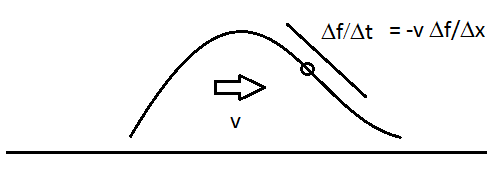

It is customary to write the partial time derivative in the lab-frame $\partial/\partial t$, while the one in the co-moving frame is written ${\rm D}/{\rm D}t$, so

\begin{equation}\tag{2}
{\rm D}f/{\rm D}t = \partial f/\partial t + {\bf v \cdot \nabla} f
\end{equation}

# Numerical Advection

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Advecting a sine-wave
We can test numerical advection by introducing a time stepping scheme, for example the second order Adams-Bashforth scheme (this can be thought of as an extrapolation in the derivative, see also the useful wikipedia entry: https://en.wikipedia.org/wiki/Linear_multistep_method ). The method can be derived in many ways, for the second order scheme we can simply match Taylor expansions forward and backwards in time:

\begin{equation}
f(t + \Delta t) = f(t) + f'(t) \Delta t + {1\over 2}f''(t) \Delta t^2 + \mathcal{O}(\Delta t^3)
\end{equation}

\begin{equation}
f'(t - \Delta t) \Delta t = f'(t) \Delta t - f''(t) \Delta t^2 + \mathcal{O}(\Delta t^3)
\end{equation}

Multiplying the second equation by $1/2$ and adding them together we find after rearrangement
\begin{equation}
f(t + \Delta t) = f(t) + {3\over 2}f'(t) \Delta t - {1\over 2}f'(t-\Delta t) \Delta t + \mathcal{O}(\Delta t^3)
\end{equation}

In [2]:
def adams_bashforth(f0,f1,dfdt,dt):
    """ 2nd order Adams-Bashforth time stepping scheme:
        f1: function at time t
        f0: function at time t-dt
        dfdt: procedure giving the time derivative
    """
    return f1+dt*(1.5*dfdt(f1)-0.5*dfdt(f0))

Let us use this to advect the function f(x) with velocity $v$, using a time step equal to `courant*ds/v`, where `ds` is the cell size, and `v` is the velocity amplitude:

#### Initial condition

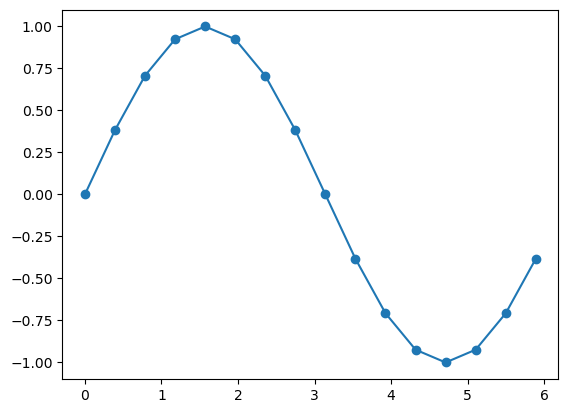

In [3]:
n=16
v=1.0
def coordinates(n):
    ds=2.0*np.pi/n
    x=ds*np.arange(n)
    return ds,x
def IC(x,v,t):
    f=np.sin(x-v*t)
    return f
ds,x=coordinates(n)
f0=IC(x,v,0.0)
plt.plot(x,f0,'-o');

#### Courant condition
This routine computes the maximum _wavespeed_ -- simply $v$ for advection -- and sets the timestep such that features in the solution do not propagate more than $C\times\Delta x$, a $C$ fraction of a cell, from one iteration to the next.

In [4]:
v=1.0
def courant(C,v,ds):
    dt=C/np.max(v/ds)
    return dt
dt=courant(0.2,v,ds)
print('dt={:.4f}'.format(dt))

dt=0.0785


#### Time derivative procedure:
Define the derivative operator and use it to construct the time-derivative with a _second order in space_ correct result

In [5]:
def deriv(f,ds,axis=0):
    return (np.roll(f,-1,axis)-np.roll(f,+1,axis))/(2.0*ds)

def deriv4(f,ds,axis=0):
    rollf = lambda n: np.roll(f, n, axis = axis)
    return -(8*(rollf(1) - rollf(-1)) - (rollf(2) - rollf(-2)))/(12.0*ds)
    
def dfdt4(f):
    return -v*deriv4(f,ds,0)

def dfdt(f):
    return -v*deriv(f,ds,0)

#### 10 time steps
Let us construct an initial condition, and a _time evolution loop_ that updates the function values according to our PDE describing advection

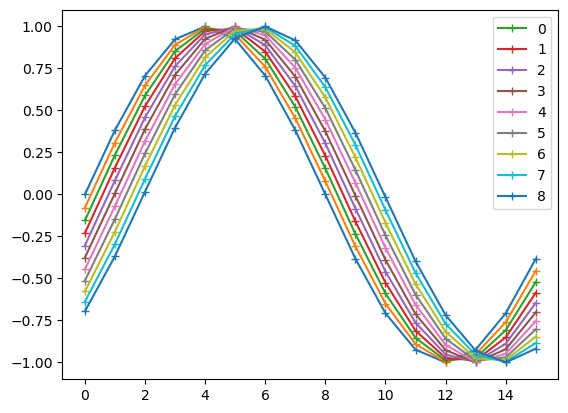

In [6]:
n=16
v=1.0
C=0.2
ds,x=coordinates(n)
dt=courant(C,v,ds)
f0=IC(x,v,0.0)                        # set "old time" f0 = f(0)
f1=IC(x,v,dt)                         # set "current time" f1 = f(dt)
plt.plot(f0,'-+')
plt.plot(f1,'-+')
for it in range(9):
    f2=adams_bashforth(f0,f1,dfdt,dt) # calculate new time f(t+dt)
    f0=f1                             # set "old time" f0 == f(t)
    f1=f2                             # set "current time" f1 == f(t+dt) = f2
    plt.plot(f1,'-+',label=it)
plt.legend();

So, this seems to work pretty well, right?  Looking at the plus symbols, we can see that the sine wave has moved about 2 cells, which is consistent with 10 time steps with 0.2 of a cell per time step.

So, let's try as many steps as would be needed for a full period; i.e, `n` cells:

We need 80 steps
End time / 2 pi: 1.000000000000002


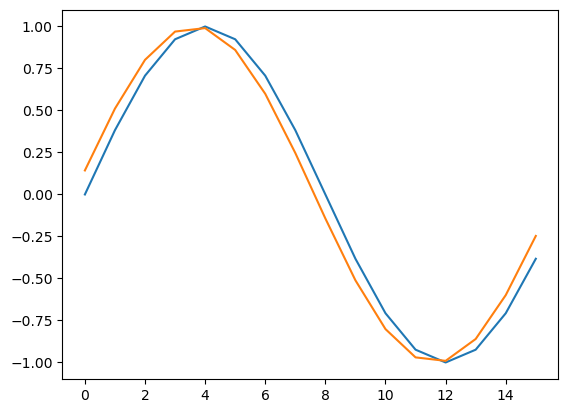

In [7]:
n=16
ds,x=coordinates(n)
dt=courant(C,v,ds)
f0=IC(x,v,0.0)                        # set "old time" f0 = f(0)
f1=IC(x,v,dt)                         # set "current time" f1 = f(dt)
plt.plot(f0)
nt=int(n/C+0.5)
print('We need {} steps'.format(nt))
t = dt
for it in range(nt-1):                # do one step less because we start at t = dt
    f2=adams_bashforth(f0,f1,dfdt,dt)
    f0=f1
    f1=f2
    t += dt
print("End time / 2 pi:", t / (2 * np.pi))
plt.plot(f2);

Close, but not exact, so let's compute a measure of the error (slightly different from last exercise, namely the RMS error):

In [8]:
f0 = IC(x,v,0.0)
RMS2 = np.average((f0-f2)**2)**0.5
print('The root-mean-square error is {:.6f}'.format(RMS2))

The root-mean-square error is 0.101364


Now it's interesting to see how the error varies with the number of points `n`:

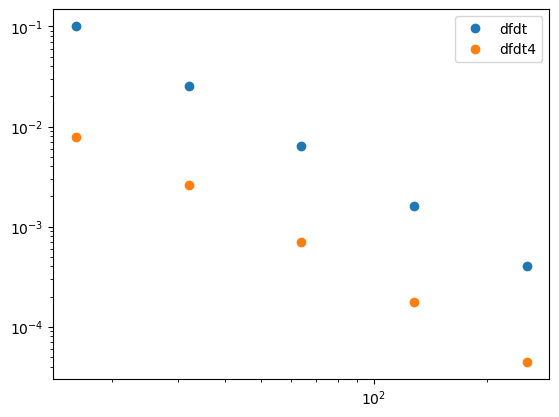

In [13]:

for df_fn in (dfdt, dfdt4):
    N=[]
    RMS2=[]
    for n in (16,32,64,128,256):
        ds,x=coordinates(n)
        dt=courant(C,v,ds)
        f0=IC(x,v,0.0)
        f1=IC(x,v,dt)
        nt=int(n/C+0.5)
        for it in range(nt-1):
            f2=adams_bashforth(f0,f1,df_fn,dt)
            f0=f1
            f1=f2
        f0=IC(x,v,0.0)
        rms=np.average((f0-f2)**2)**0.5
        N.append(n)
        RMS2.append(rms)
    plt.loglog(N,RMS2,'o', label=df_fn.__name__);

plt.legend()

Let's try and fit a line through, observing that the errors seems to drop with a factor of 4 for each step of 2 in `n`:

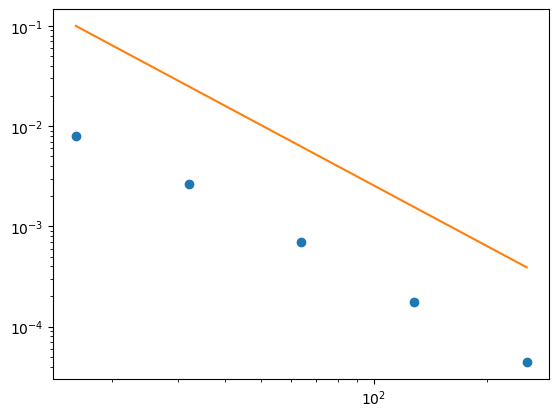

In [14]:
plt.loglog(N,RMS2,'o');
N=np.array(N)
plt.loglog(N,0.1/(N/16.0)**2);

We conclude that the error drops with $1/n^2 \sim dx^2 \sim dt^2$; i.e., the prodedure is _second order accurate in the resolution and in the timestep_. 

Second order accuracy means that after advecting a function a fixed amount of time, with a timestep that is reduced according to the cell size, the error scales as $1/n^2$.

#### __Task 1:__

Replace the `deriv()` procedure with your 4th order accurate version, and repeat the computation, but store the error as `RMS4` (so you can plot both in the same plot).  
   * What is the accuracy order of the improved procedure?
   * The answer may seem surprising (or not).  Discuss!

ANSWER:

Hmm it seems like it is also second order!?


### Errors become visible when advecting a square wave
So, this seems rather good, then -- one can get very small advection errors, by choosing high spatial order.  But the problem is the dependence of the errors on the number of points in the sine wave.  One can think of the error as an error in _phase_ of the sine wave (there is also an error in amplitude, but the error in phase is more apparent in this example).

Errors in amplitude and phase of sin/cos waves translate to _dispersion_ of shapes that has "overtones"; i.e., functions whose Fourier transform contains higher wave numbers because the relative resolution of the different wave numbers.

#### To illustrate _dispersion_, let's make a square(-ish) wave, for testing:

Such a wave may be though of as a superposition of sine-waves.  A _Fourier transform_ would give the individual amplitudes

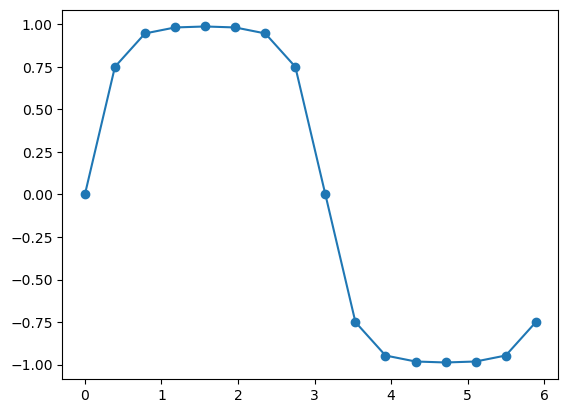

In [15]:
n=16
ds,x=coordinates(n)
def square_wave(x,v,ds,t,steepness=1.0):
    f=IC(x,v,t)
    return np.tanh((steepness/ds)*f)
f0=square_wave(x,v,ds,0.0)
plt.plot(x,f0,'-o');

We try to evolve it for 10 time steps again, using a copy & paste of what we did before, just with the `square_wave()` as the initial condition, and plotting only the initial and final states:

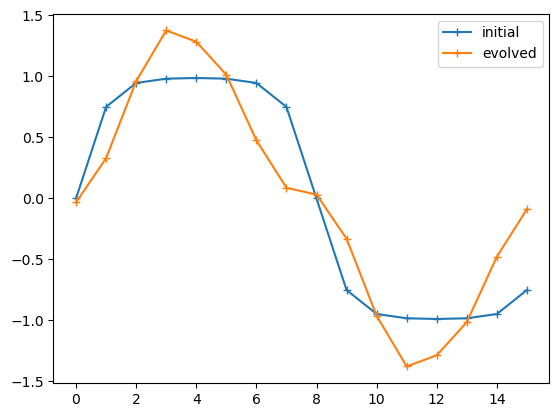

In [16]:
n=16
C=0.2
ds,x=coordinates(n)
dt=courant(C,v,ds)
nt=int(n/C+0.5)
f0=square_wave(x,v,ds,0.0)
f1=square_wave(x,v,ds,dt)
plt.plot(f0,'-+',label='initial')
for it in range(nt-1):
    f2=adams_bashforth(f0,f1,dfdt,dt)
    f0=f1
    f1=f2
plt.plot(f2,'-+',label='evolved')
plt.legend();

The "square" wave has already become pretty distorted!

Let's repeat this for n=32

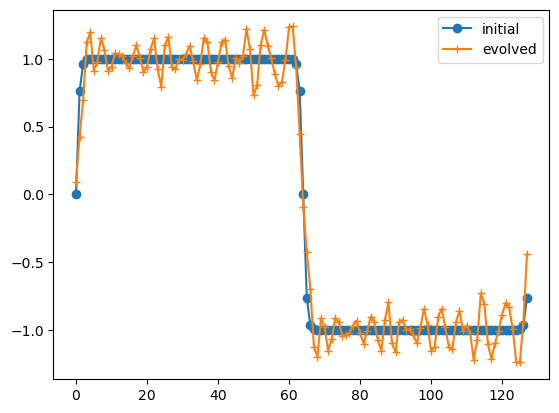

In [19]:
n=128
C=0.2
ds,x=coordinates(n)
dt=courant(C,v,ds)
nt=int(n/C+0.5)
f0=square_wave(x,v,ds,0.0)
f1=square_wave(x,v,ds,dt)
plt.plot(f0,'-o',label='initial')
for it in range(nt-1):
    f2=adams_bashforth(f0,f1,dfdt4,dt)
    f0=f1
    f1=f2
plt.plot(f2,'-+',label='evolved')
plt.legend();

The error at the front of the square wave looks exactly the same!  Try with `n=64` and `n=128`, to confirm!

The result is not encouraging; the error remains essentially the same, which shows that the problem cannot be solved by increasing the number of points.

#### __Task 2:__ Try using the 4th order derivative

Try, as above, to replace the 2nd order derivative with the 4th order derivative.  Does the problem go away? Why did we have a problem in the first place (_hint_: think of a square wave as a sum of waves with many different wavelengths)

- Something-something fourier transform of square wave => flat and discontinous

#### __Absalon turn-in:__

Answer the questions in Task 1 and 2 in the notebook and upload the notebook together with a PDF file of the notebook.